# **🔬 Définition du problème :**

\
En partant d'une image, pouvons-nous prédire la classe correcte de cette image ?

Les images sont très petites (32x32), et en les visualisant, vous remarquerez à quel point il est difficile de les distinguer même pour un être humain.

Dans ce notebook, nous allons construire un modèle de réseau neuronal convolutif (CNN) capable de classifier des images représentant divers objets. Nous disposons de 10 classes d'images :

* Avion
* Automobile
* Oiseau
* Chat
* Daim
* Chien
* Grenouille
* Cheval
* Navire
* Camion

 ## Importation des bibliothèques :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 📥 Load the data : 

Chargement du jeu de données CIFAR-10 à partir de la bibliothèque TensorFlow

In [2]:
# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


## Visualisation de données :

Cette section prépare et visualise de manière aléatoire des échantillons du jeu de données CIFAR-10, mettant en évidence les diverses classes présentes dans le dataset.

In [3]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

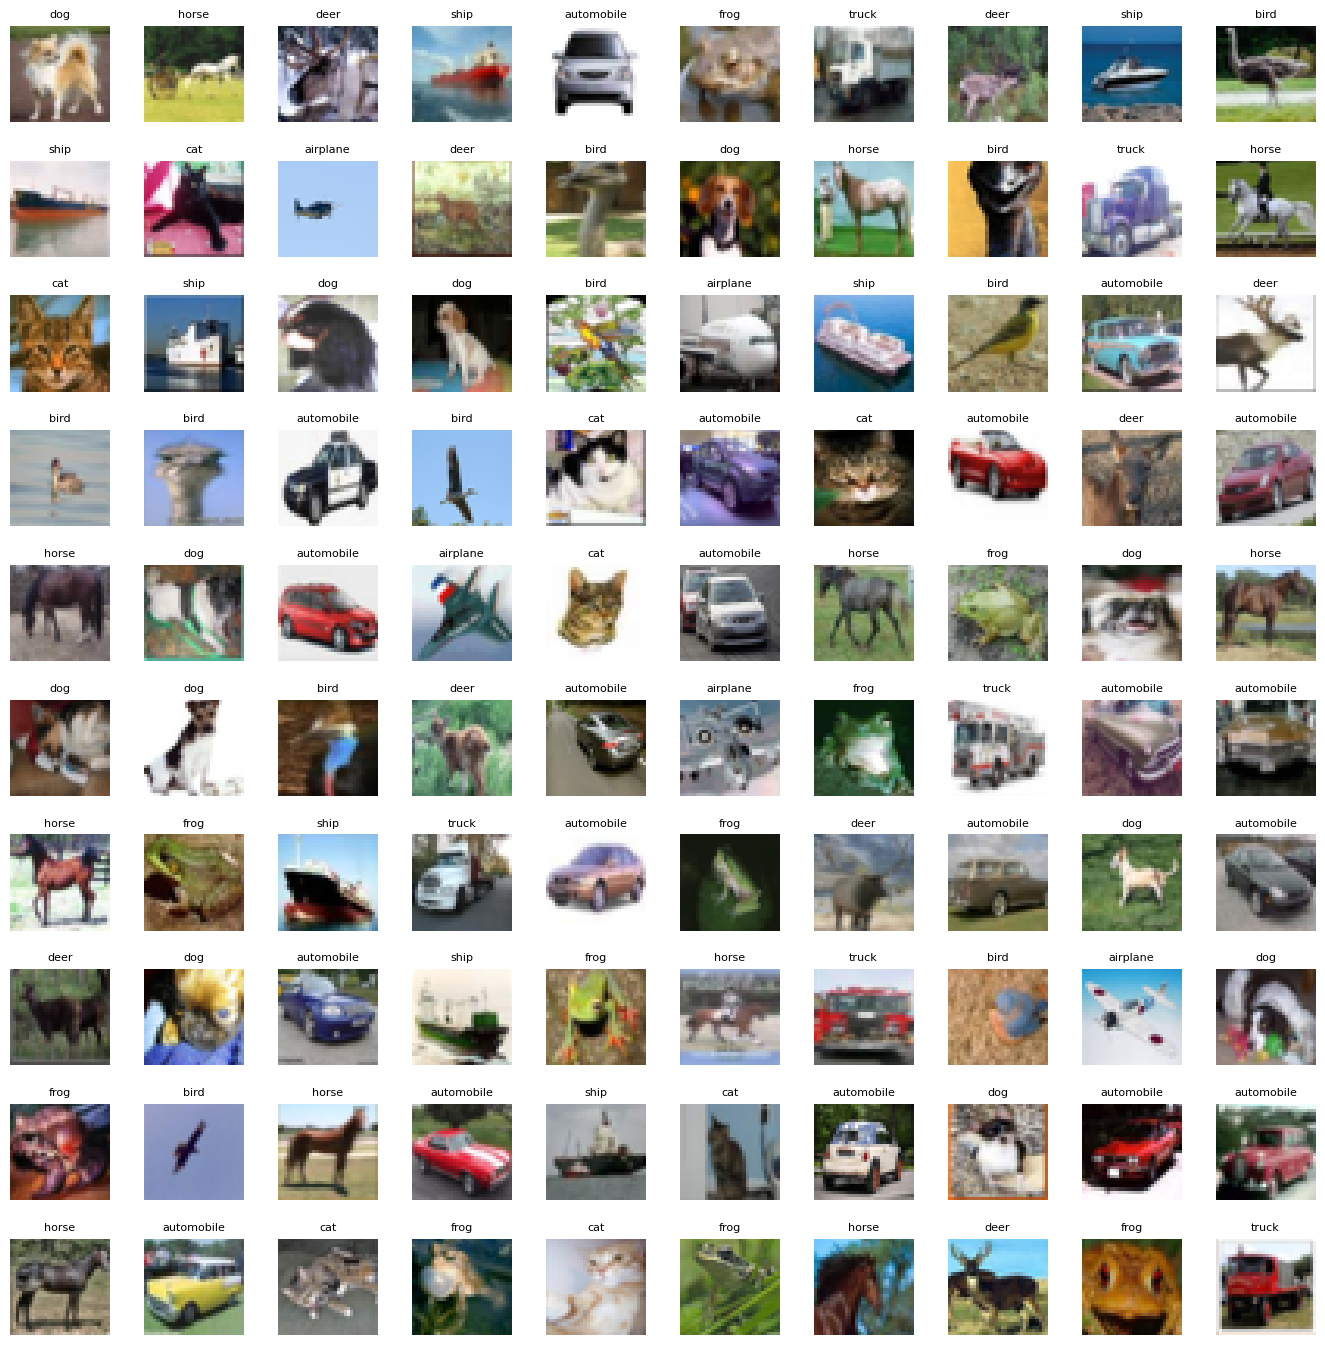

In [4]:

# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 10
L_grid = 10

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(X_train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow(X_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)


## 🔄 Prétraitement des données :

de code effectue le prétraitement des données pour les rendre adaptées à l'entraînement du modèle CNN.En normalisant les valeurs des pixels, en encodant les étiquettes en one-hot, et en appliquant une augmentation de données pour diversifier l'ensemble d'entraînement.

In [5]:

# Normalize pixel values to be between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

In [6]:
# Transform target variable into one-hot encoding
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

In [7]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

In [8]:
datagen.fit(X_train)

## 🤖 Construction de modèle :

L'architecture du réseau neuronal convolutif (CNN) :
1. **Couches Convolutionnelles :**
    *     Deux ensembles de deux couches Conv2D avec activation 'relu' et initialisation 'he_normal'.
    * Utilisation de BatchNormalization pour normaliser les activations.
    * MaxPooling2D après chaque ensemble pour réduire la dimensionnalité.
2. **Couches de Régularisation :**
    * Couches Dropout après chaque MaxPooling2D pour prévenir le surapprentissage.
3. **Couches Entièrement Connectées :**
    * Une couche Flatten suivie de deux couches Dense.
    * La première couche Dense a 512 neurones avec activation 'relu'.
    * Utilisation de BatchNormalization et Dropout (0.5) pour la régularisation.
    * Couche de sortie avec activation 'softmax' et 10 neurones correspondant aux classes.

In [9]:
# Model Architecture
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                        

In [11]:
# Model Compilation
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Training
history = model.fit(
    datagen.flow(X_train, y_cat_train, batch_size=32),
    epochs=50,
    validation_data=(X_test, y_cat_test),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
    ]
)


Epoch 1/50


2024-01-12 10:25:02.898158: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1563/1563 [==============================] - 41s 21ms/step - loss: 1.6988 - accuracy: 0.4227 - val_loss: 1.2649 - val_accuracy: 0.5597 - lr: 0.0010
Epoch 2/50
1563/1563 [==============================] - 32s 20ms/step - loss: 1.1607 - accuracy: 0.5871 - val_loss: 1.0871 - val_accuracy: 0.6508 - lr: 0.0010
Epoch 3/50
1563/1563 [==============================] - 31s 20ms/step - loss: 0.9936 - accuracy: 0.6521 - val_loss: 1.0043 - val_accuracy: 0.6547 - lr: 0.0010
Epoch 4/50
1563/1563 [==============================] - 32s 20ms/step - loss: 0.9057 - accuracy: 0.6866 - val_loss: 0.7395 - val_accuracy: 0.7443 - lr: 0.0010
Epoch 5/50
1563/1563 [==============================] - 32s 20ms/step - loss: 0.8183 - accuracy: 0.7184 - val_loss: 0.7633 - val_accuracy: 0.7391 - lr: 0.0010
Epoch 6/50
1563/1563 [==============================] - 32s 20ms/step - loss: 0.7591 - accuracy: 0.7401 - val_loss: 0.7310 - val_accuracy: 0.7528 - lr: 0.0010
Epoch 7/50
1563/1563 [==============================] - 3

## 📊 Model Evaluation :

In [13]:
# Evaluate the model
model.evaluate(X_test, y_cat_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.3492 - accuracy: 0.8827


[0.34915077686309814, 0.8827000260353088]

In [14]:
# Model Evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_cat_test, axis=1)

313/313 [==============================] - 1s 3ms/step


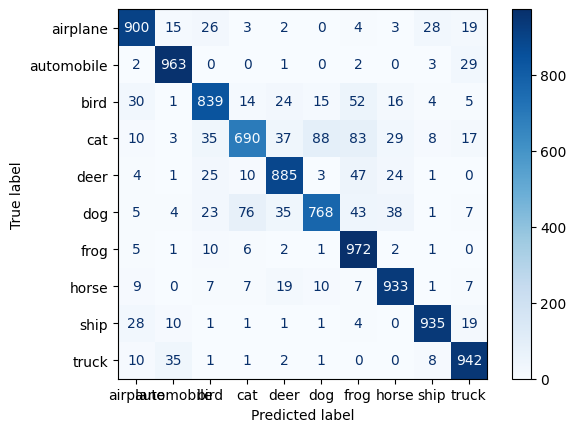

In [16]:
# Display confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Le rapport de classification fournit une évaluation de la performance du modèle par classe. Les principales métriques incluent la précision, le rappel , et le F1-score ... Globalement, le modèle atteint une précision de 89% sur l'ensemble de test, mais les performances varient selon les classes.

In [17]:
# Display classification report
class_report = classification_report(y_true, y_pred_classes,target_names=labels)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

    airplane       0.90      0.90      0.90      1000
  automobile       0.93      0.96      0.95      1000
        bird       0.87      0.84      0.85      1000
         cat       0.85      0.69      0.76      1000
        deer       0.88      0.89      0.88      1000
         dog       0.87      0.77      0.81      1000
        frog       0.80      0.97      0.88      1000
       horse       0.89      0.93      0.91      1000
        ship       0.94      0.94      0.94      1000
       truck       0.90      0.94      0.92      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



cette section crée une visualisation claire de l'évolution des métriques du modèle au fil des époques

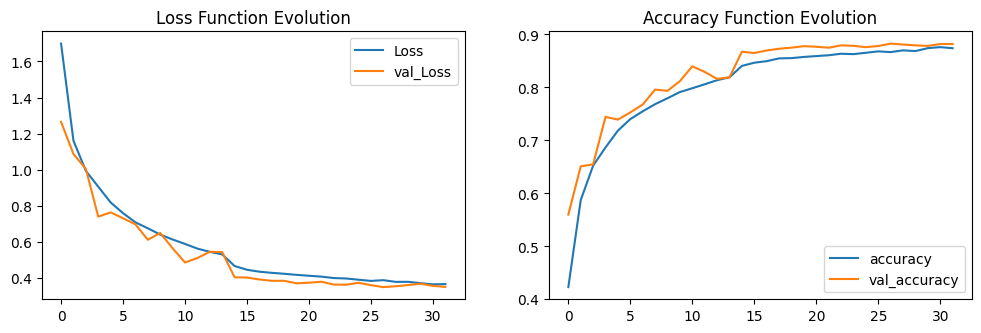

In [24]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()


plt.show()


## Phase du test :

L'image 20 est : Horse
1/1 [==============================] - 0s 19ms/step
Le modèle prédit que l'image 20 est : Horse


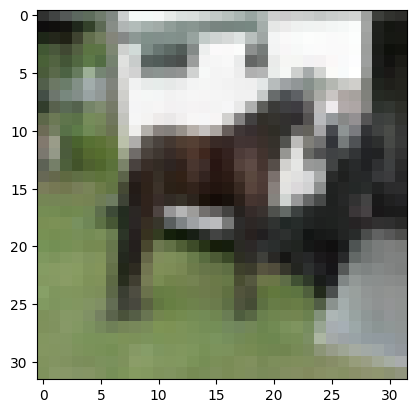

In [36]:
# Mapping des indices aux noms de classe
class_labels = {
    0: 'Airplane',
    1: 'Automobile',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck'
}

my_image = X_test[20]
plt.imshow(my_image)

# Le label réel de l'image 20
actual_label_index = y_test[20][0]  # Extraire la valeur scalaire de l'array numpy
actual_label = class_labels[actual_label_index]
print(f"L'image 20 est : {actual_label}")

# Prédiction du modèle pour l'image 20
pred_index = np.argmax(model.predict(my_image.reshape(1, 32, 32, 3)))
predicted_label = class_labels[pred_index]
print(f"Le modèle prédit que l'image 20 est : {predicted_label}")


L'image 197 est : Ship
1/1 [==============================] - 0s 19ms/step
Le modèle prédit que l'image 197 est : Ship


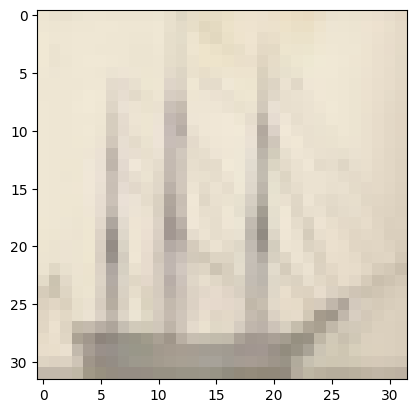

In [37]:
my_image = X_test[197]
plt.imshow(my_image)

# Le label réel de l'image 20
actual_label_index = y_test[197][0]  # Extraire la valeur scalaire de l'array numpy
actual_label = class_labels[actual_label_index]
print(f"L'image 197 est : {actual_label}")

# Prédiction du modèle pour l'image 20
pred_index = np.argmax(model.predict(my_image.reshape(1, 32, 32, 3)))
predicted_label = class_labels[pred_index]
print(f"Le modèle prédit que l'image 197 est : {predicted_label}")

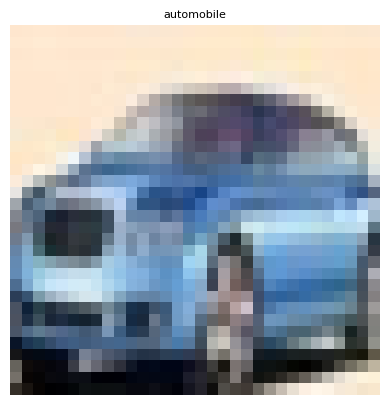

In [40]:
# Lire et afficher une image avec l'indice sélectionné
index = np.random.randint(0, n_test)
my_image = X_test[index]
plt.imshow(my_image)

# Obtenir l'indice de la classe prédite
pred_index = np.argmax(y_pred[index])

# Afficher le label prédit sur l'image
plt.title(labels[pred_index], fontsize=8)
plt.axis('off')
plt.show()

## Save the model:

In [42]:
# Sauvegarder le modèle au format natif Keras
model.save('cnn_20_epochs', save_format='tf')
